In [4]:
#########################################################################################################################
################################################### LOADING AND LABEL ###################################################
#########################################################################################################################

In [1]:
!python --version
!conda --version

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
!pip install 'h5py==2.10.0' --force-reinstall

import sys
!{sys.executable} -m pip install -U segmentation-models
import segmentation_models as sm 
#!{sys.executable} -m pip install -U albumentations>=0.3.0
!{sys.executable} -m pip install -U albumentations[imgaug]
!{sys.executable} -m pip install glob2

#from skimage.io import imread, imshow
#from skimage.transform import resize

Python 3.7.13
conda 4.12.0


2022-12-23 06:55:40.767065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 06:55:40.878469: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-23 06:55:41.364181: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-23 06:55:41.364227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.1.0 requires scipy==1.4.1; python_version >= "3", but you have scipy 1.7.3 which is incompatible.
tensorflow 2.1.0 requires tensorboard<2.2.0,>=2.1.0, 

In [2]:
DATA_DIR = './data_224_seg/segmentation_224_withoutFullPositive/'

x_train_dir = os.path.join(DATA_DIR, 'train/image/img')
y_train_dir = os.path.join(DATA_DIR, 'train/mask/img')

x_valid_dir = os.path.join(DATA_DIR, 'val/image/img')
y_valid_dir = os.path.join(DATA_DIR, 'val/mask/img')

x_test_dir = os.path.join(DATA_DIR, 'test/image/img')
y_test_dir = os.path.join(DATA_DIR, 'test/mask/img')

In [23]:
import os.path

path = x_test_dir

num_files = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
print(path)
print(num_files)

./data_224_seg/segmentation_224_withoutFullPositive/test/image/img
3410


In [3]:
import os
import tensorflow as tf

from glob2 import glob

def process_img(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=(28, 28))
    return img

x_train_files = glob(x_train_dir + '/*.jpg')
y_train_files = glob(y_train_dir + '/*.jpg')

train_files_ds = tf.data.Dataset.from_tensor_slices((x_train_files, y_train_files))

train_files_ds = train_files_ds.map(lambda x, y: (process_img(x), process_img(y))).batch(1)

x_train, y_train = next(iter(train_files_ds))

#print(y_train)

2022-12-23 06:55:52.633473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 06:55:53.082697: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13643 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:41:00.0, compute capability: 7.5


In [4]:
x_val_files = glob(x_valid_dir + '/*.jpg')
y_val_files = glob(y_valid_dir + '/*.jpg')

val_files_ds = tf.data.Dataset.from_tensor_slices((x_val_files, y_val_files))
val_files_ds = val_files_ds.map(lambda n, h: (process_img(n), process_img(h))).batch(1)
x_val, y_val = next(iter(val_files_ds))

x_test_files = glob(x_test_dir + '/*.jpg')
y_test_files = glob(y_test_dir + '/*.jpg')

test_files_ds = tf.data.Dataset.from_tensor_slices((x_test_files, y_test_files))
test_files_ds = test_files_ds.map(lambda x, y: (process_img(x), process_img(y))).batch(1)
x_test, y_test = next(iter(test_files_ds))

#print(x_val)
#print(y_val)
#print(len(x_val))

In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:    
    CLASSES = ['metastasis']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [6]:
import albumentations as A
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=224, min_width=224, always_apply=True, border_mode=0),
        A.RandomCrop(height=224, width=224, always_apply=True),

        A.transforms.GaussNoise (p=0.2),
        A.geometric.transforms.Perspective (p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.transforms.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(224, 224)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [7]:
BACKBONE = 'resnet50'
# resnet50_imagenet_1000_no_top.h5
BATCH_SIZE = 8
CLASSES = ['metastasis']
#LR = 0.0001
LR = 0.00001
EPOCHS = 30

preprocess_input = sm.get_preprocessing(BACKBONE)

In [8]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [9]:
# define optomizer
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [10]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 224, 224, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 224, 224, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving


In [11]:
BEST_MODEL_FILEPATH = './models/best_model_014.h5'

learn_control = tf.keras.callbacks.ReduceLROnPlateau(monitor='iou_score',
                                                      patience=5,
                                                      verbose=1,
                                                      factor=0.2,
                                                      min_lr=1e-7)

# ModelCheckpoint: When training requires a lot of time to achieve a good result, 
# often many iterations are required. In this case, it is better to save a copy 
# of the best performing model only when an epoch that improves the metrics ends.

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_FILEPATH, 
                                                 monitor='iou_score', 
                                                 verbose=1, 
                                                 save_best_only=True, 
                                                 mode='max'
                                                 )


In [12]:
BEST_MODEL_FILEPATH = './models/best_model_014.h5'

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_FILEPATH, 
                                       save_weights_only=True, 
                                       save_best_only=True, 
                                       mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
]

In [13]:
print(len(train_dataloader))
print(len(valid_dataloader))

2097
1928


In [14]:
# train model
history = model.fit(
    train_dataloader,
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/30


2022-12-23 06:56:43.433368: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


2097/2097 [==============================] - 397s 186ms/step - loss: 0.5662 - iou_score: 0.4522 - f1-score: 0.6134 - val_loss: 0.5894 - val_iou_score: 0.4729 - val_f1-score: 0.5812 - lr: 1.0000e-05
Epoch 2/30
2097/2097 [==============================] - 385s 183ms/step - loss: 0.4638 - iou_score: 0.5650 - f1-score: 0.7171 - val_loss: 0.6311 - val_iou_score: 0.4470 - val_f1-score: 0.5558 - lr: 1.0000e-05
Epoch 3/30
2097/2097 [==============================] - 384s 183ms/step - loss: 0.2875 - iou_score: 0.7309 - f1-score: 0.8423 - val_loss: 0.7262 - val_iou_score: 0.4200 - val_f1-score: 0.5292 - lr: 1.0000e-05
Epoch 4/30
2097/2097 [==============================] - 384s 183ms/step - loss: 0.1922 - iou_score: 0.8198 - f1-score: 0.9001 - val_loss: 0.7703 - val_iou_score: 0.3995 - val_f1-score: 0.5081 - lr: 1.0000e-05
Epoch 5/30
2097/2097 [==============================] - 385s 184ms/step - loss: 0.1616 - iou_score: 0.8428 - f1-score: 0.9140 - val_loss: 0.7752 - val_iou_score: 0.4337 - val_

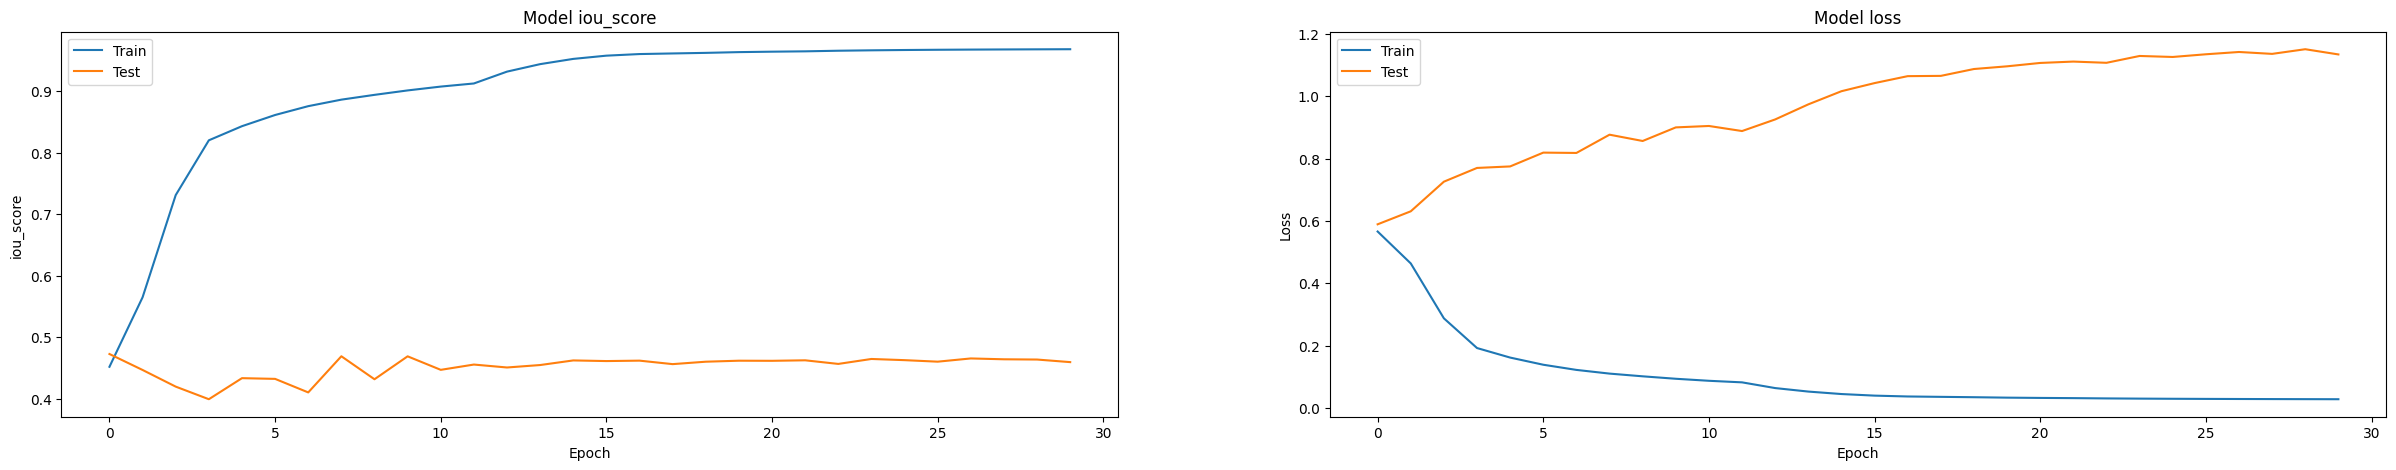

In [15]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [ ]:
joined_generator = test_dataset
images, masks = next(joined_generator)

print(masks[0].shape, images[0].shape)

In [ ]:
image = np.expand_dims(test_dataset[0], axis=0)

In [17]:
# load best weights
model.load_weights(BEST_MODEL_FILEPATH) 

In [18]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/tmp/ipykernel_3118264/3518042878.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_dataloader)


Loss: 0.62596
mean iou_score: 0.48975
mean f1-score: 0.60218


1/1 [==============================] - 0s 26ms/step


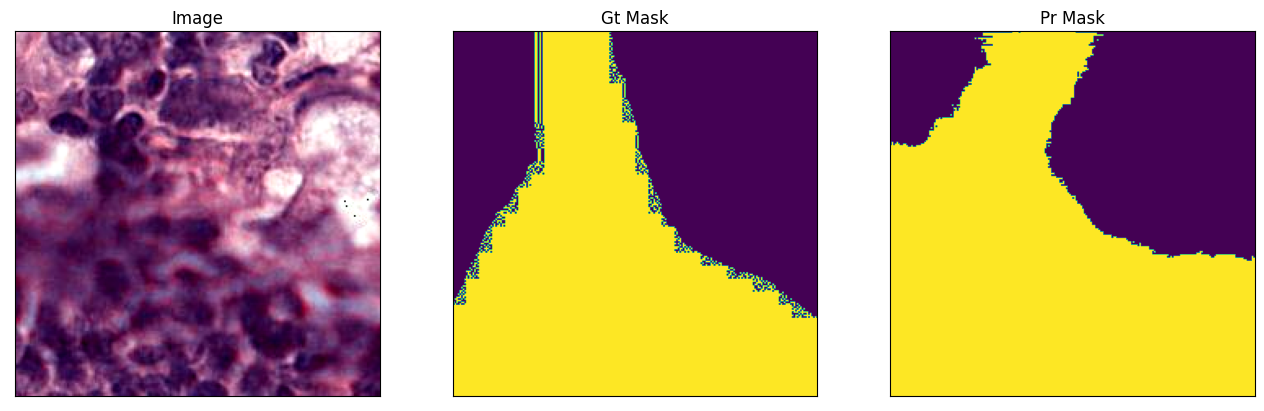

1/1 [==============================] - 0s 22ms/step


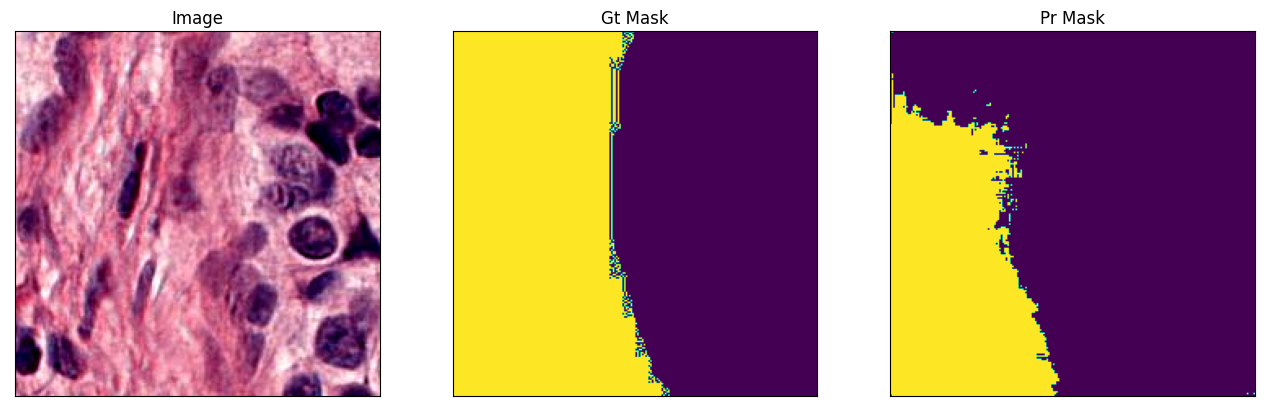

1/1 [==============================] - 0s 22ms/step


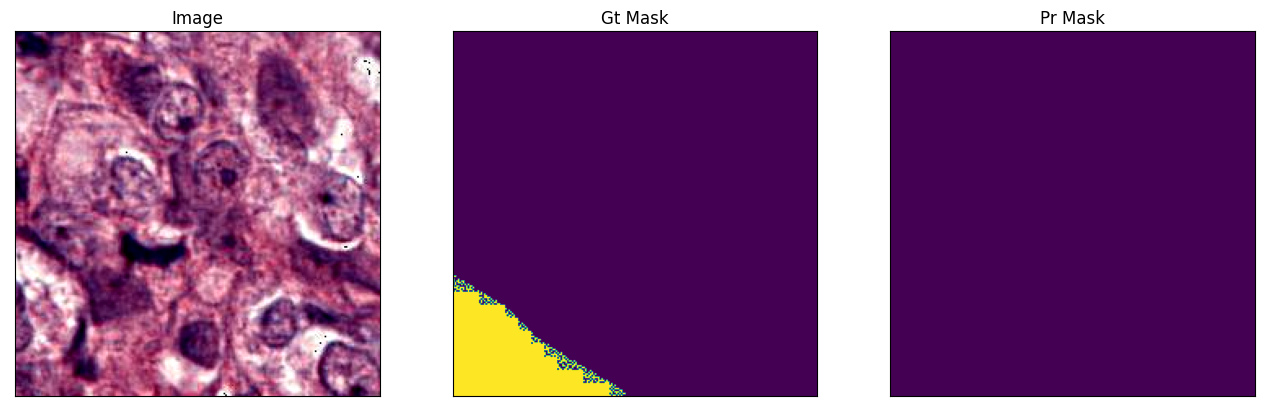

1/1 [==============================] - 0s 22ms/step


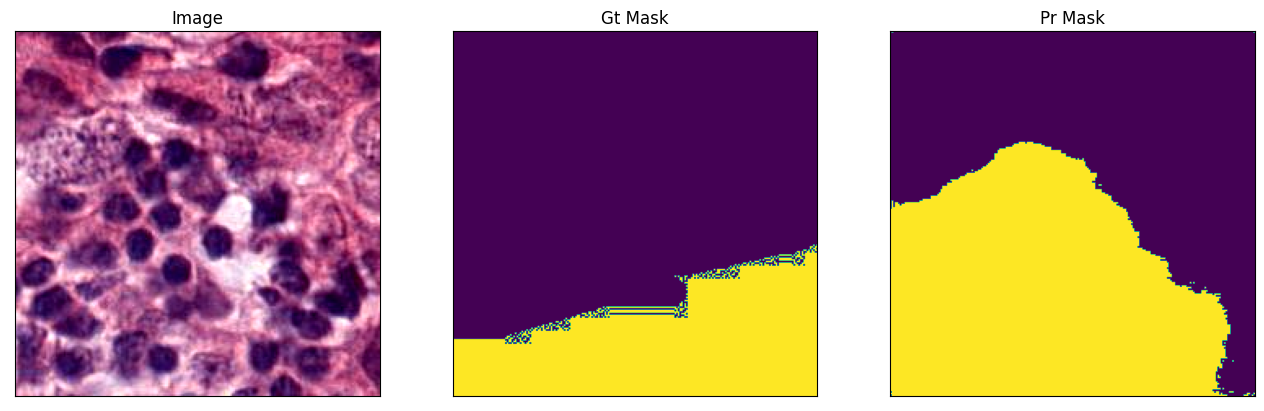

1/1 [==============================] - 0s 22ms/step


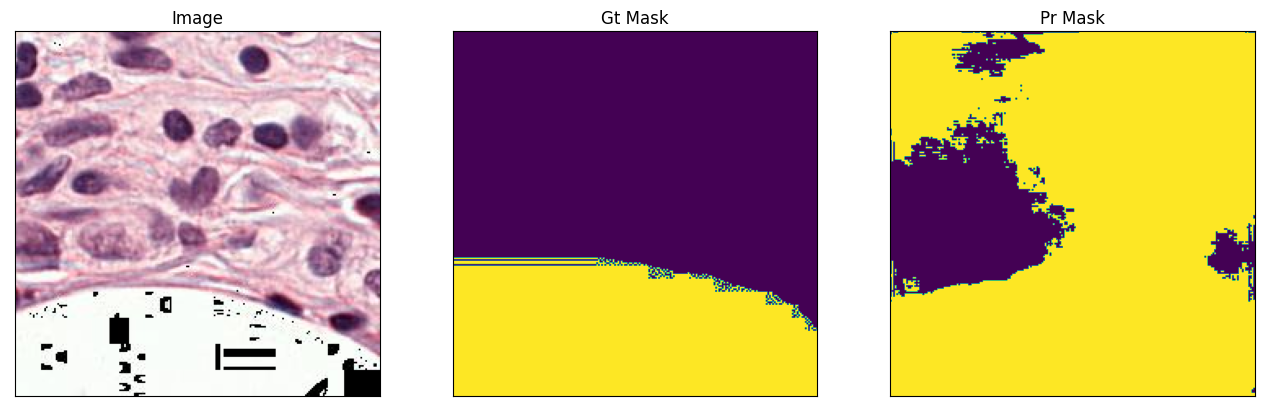

In [25]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

In [ ]:
nsi